<h1><center> Heart Failure Prediction Modeling </center></h1>

## 1.0 Modeling 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_rows",None) #full dataset loading in notebook view
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [2]:
# The supplied CSV data file is the raw_data directory
# Create a Dataframe 

heart_df = pd.read_csv('../HeartFailurePrediction/data/heart.csv')

In [3]:
# Checking the columns and the first 5 rows 
heart_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


## 1.1 One Hot Encoding 

In [4]:
def OneHotEncoding(dfcolumn):
    global heart_df
    dfcolumn.nunique()
    len(heart_df.columns)
    finallencol = (dfcolumn.nunique() - 1) + (len(heart_df.columns)-1)
    dummies = pd.get_dummies(dfcolumn, drop_first=True, prefix=dfcolumn.name)
    heart_df = pd.concat([heart_df, dummies], axis='columns')
    heart_df.drop(columns=dfcolumn.name, axis=1, inplace=True) 
    if finallencol == len(heart_df.columns):
        print('OneHotEncoding is successful') 
        print('')
    else:
        print('Unsuccessful')
    return heart_df.head(5)

In [5]:
OneHotEncoding(heart_df['ChestPainType'])
OneHotEncoding(heart_df['Sex'])
OneHotEncoding(heart_df['RestingECG'])
OneHotEncoding(heart_df['ExerciseAngina'])
OneHotEncoding(heart_df['ST_Slope'])

OneHotEncoding is successful

OneHotEncoding is successful

OneHotEncoding is successful

OneHotEncoding is successful

OneHotEncoding is successful



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,False,False,True,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,True,False,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,False,False,True,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,False,True,False,True,True,False,False,False,True


In [6]:
# Convert True/False values to 1/0
heart_df = heart_df.astype(int)

In [7]:
heart_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,0,0,1,1,0,0,0,1
1,49,160,180,0,156,1,1,0,1,0,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,0,0,1,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,0,1,0,1,1,0,0,0,1


In [8]:
heart_df.describe().columns.to_list()

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'Sex_M',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'ST_Slope_Up']

## 1.2 Imputation

In [9]:
from sklearn.impute import KNNImputer

# Replace zero values with NaN using .loc
heart_df.loc[heart_df['Cholesterol'] == 0, 'Cholesterol'] = np.nan

# Initialize KNNImputer
KNN_imputer = KNNImputer(n_neighbors=5)

# Impute missing values using KNNImputer
heart_df['Cholesterol'] = KNN_imputer.fit_transform(heart_df[['Cholesterol']])

# Convert the column to int type if necessary
heart_df['Cholesterol'] = heart_df['Cholesterol'].astype(int)


## 1.3 Feature Scaling

In [10]:
# altering the DataFrame
df = heart_df[['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'Sex_M',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'HeartDisease',]]
 
# printing the altered DataFrame
df.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0,1,0,0,1,1,0,0,0,1,0
1,49,160,180,0,156,1,0,1,0,0,1,0,0,1,0,1
2,37,130,283,0,98,0,1,0,0,1,0,1,0,0,1,0
3,48,138,214,0,108,1,0,0,0,0,1,0,1,1,0,1
4,54,150,195,0,122,0,0,1,0,1,1,0,0,0,1,0


In [11]:
scaler = StandardScaler()
scaler.fit(heart_df.drop('HeartDisease',axis = 1))

StandardScaler()

In [12]:
scaled_features = scaler.transform(df.drop('HeartDisease',axis = 1))
df_feat = pd.DataFrame(scaled_features,columns = heart_df.columns[:-1])
df_feat.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat
0,-1.433140,0.410909,0.834754,-0.551341,1.382928,-0.727592,2.075177,-0.532838,-0.229679,0.515952,0.814275,-0.490449,-0.823556,-1.002181,1.150674
1,-0.478484,1.491752,-1.210675,-0.551341,0.754157,0.282891,-0.481887,1.876744,-0.229679,-1.938163,0.814275,-0.490449,-0.823556,0.997824,-0.869056
2,-1.751359,-0.129513,0.722161,-0.551341,-1.525138,-0.727592,2.075177,-0.532838,-0.229679,0.515952,-1.228087,2.038947,-0.823556,-1.002181,1.150674
3,-0.584556,0.302825,-0.572651,-0.551341,-1.132156,0.282891,-0.481887,-0.532838,-0.229679,-1.938163,0.814275,-0.490449,1.214246,0.997824,-0.869056
4,0.051881,0.951331,-0.929194,-0.551341,-0.581981,-0.727592,-0.481887,1.876744,-0.229679,0.515952,0.814275,-0.490449,-0.823556,-1.002181,1.150674


In [13]:
df.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Sex_M,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0,1,0,0,1,1,0,0,0,1,0
1,49,160,180,0,156,1,0,1,0,0,1,0,0,1,0,1
2,37,130,283,0,98,0,1,0,0,1,0,1,0,0,1,0
3,48,138,214,0,108,1,0,0,0,0,1,0,1,1,0,1
4,54,150,195,0,122,0,0,1,0,1,1,0,0,0,1,0


## 1.4 Feature Selection

In [14]:
# Get the list of column names from the description of the heart_df DataFrame
col = heart_df.describe().columns.to_list()
print(col)


['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'Sex_M', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [15]:
# Assign feature matrix X and target vector y
X = df_feat
y = heart_df['HeartDisease'] 


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)


In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)


In [18]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)  # Fit Random Forest Regressor to the training data

RandomForestRegressor(random_state=0)

In [19]:
# Import Recursive Feature Elimination with Cross-Validation (RFECV)
from sklearn.feature_selection import RFECV

# Initialize RFECV with Random Forest Regressor and cross-validation
rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")
rfe.fit(X_train,y_train)  # Fit RFECV to the training data

RFECV(cv=5, estimator=RandomForestRegressor(random_state=0),
      scoring='neg_mean_squared_error')

In [20]:
# Get selected features using the support from RFECV
selected_features = np.array(col)[rfe.get_support(16)]

In [21]:
selected_features

array(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'ChestPainType_ATA', 'ChestPainType_TA',
       'RestingECG_ST', 'ST_Slope_Flat'], dtype='<U17')

## 2.0 Model Selection

### 10-Fold Cross validation and model comparision

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the number of folds for cross-validation
cv = KFold(n_splits=10, random_state=100, shuffle=True)

# Create a K Nearest Neighbors (KNN) classifier model with 36 neighbors
model = KNeighborsClassifier(n_neighbors=36)

# Perform cross-validation on the KNN model using the accuracy metric
# and print the mean accuracy score and its standard deviation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy of KNN: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Create a Support Vector Classifier (SVC) model with radial basis function (RBF) kernel
model = SVC(kernel='rbf')

# Perform cross-validation on the SVC model using the accuracy metric
# and print the mean accuracy score and its standard deviation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy of SVC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Create a Random Forest Classifier model with 40 trees
model = RandomForestClassifier(n_estimators=40, random_state=100)

# Perform cross-validation on the Random Forest model using the accuracy metric
# and print the mean accuracy score and its standard deviation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy of RandomForest: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Accuracy of KNN: 0.858 (0.033)
Accuracy of SVC: 0.865 (0.030)
Accuracy of RandomForest: 0.861 (0.037)


## K value estimation

In [23]:
from matplotlib import pyplot

# Initialize an empty list to store error rates
error_rate = []

# Iterate over a range of values for the number of neighbors (from 1 to 39)
for i in range(1, 40):
    # Create a K Nearest Neighbors (KNN) classifier model with i neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    
    # Train the KNN model using the training data
    knn.fit(X_train, y_train)
    
    # Make predictions on the test data using the trained model
    pred_i = knn.predict(X_test)
    
    # Calculate the error rate (misclassification rate) by comparing predicted labels with actual labels
    # and append it to the error_rate list
    error_rate.append(np.mean(pred_i != y_test))
    
    # Print the current value of k (number of neighbors) and its corresponding error rate
    print(i, np.mean(pred_i != y_test))


1 0.1826086956521739
2 0.19130434782608696
3 0.15217391304347827
4 0.14347826086956522
5 0.12173913043478261
6 0.12173913043478261
7 0.11739130434782609
8 0.12608695652173912
9 0.12608695652173912
10 0.12608695652173912
11 0.12608695652173912
12 0.1391304347826087
13 0.13478260869565217
14 0.14347826086956522
15 0.1391304347826087
16 0.13043478260869565
17 0.13043478260869565
18 0.14347826086956522
19 0.13043478260869565
20 0.14347826086956522
21 0.1391304347826087
22 0.1391304347826087
23 0.13478260869565217
24 0.13478260869565217
25 0.14347826086956522
26 0.1391304347826087
27 0.15217391304347827
28 0.14782608695652175
29 0.14782608695652175
30 0.14782608695652175
31 0.14347826086956522
32 0.1391304347826087
33 0.14347826086956522
34 0.14347826086956522
35 0.14782608695652175
36 0.1391304347826087
37 0.14347826086956522
38 0.13478260869565217
39 0.1391304347826087


Text(0, 0.5, 'Error Rate')

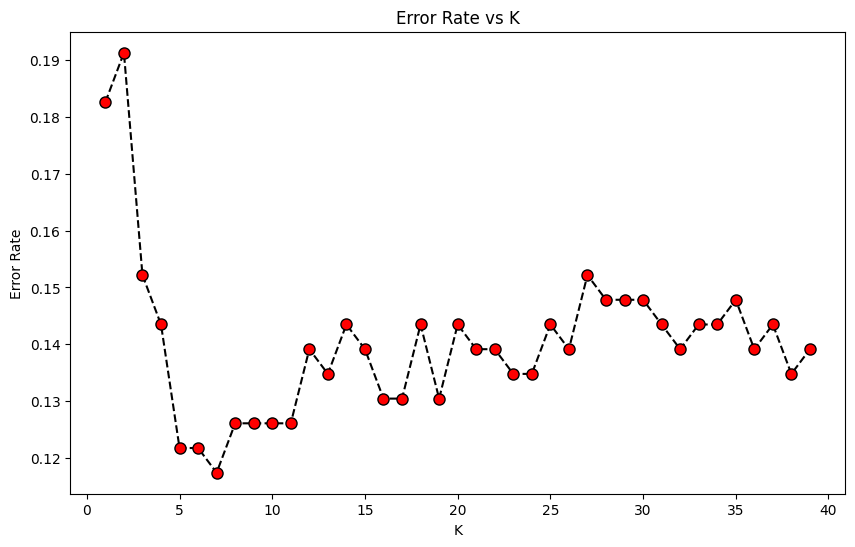

In [24]:
# Create a new figure with a specific size (width: 10 inches, height: 6 inches)
plt.figure(figsize=(10, 6))

# Plot the error_rate values against the values of K (number of neighbors)
# The x-axis represents the range of values from 1 to 39 (number of neighbors)
# The y-axis represents the corresponding error rates calculated previously
plt.plot(range(1, 40), error_rate, color='black', linestyle='--', marker='o', markerfacecolor='red', markersize=8)

# Set the title of the plot
plt.title('Error Rate vs K')

# Label the x-axis as 'K' (number of neighbors)
plt.xlabel('K')

# Label the y-axis as 'Error Rate'
plt.ylabel('Error Rate')

# Display the plot


## KNN model

              precision    recall  f1-score   support

           0       0.90      0.80      0.84       108
           1       0.84      0.92      0.88       122

    accuracy                           0.86       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230



------------------------
Confusion Matrix
------------------------



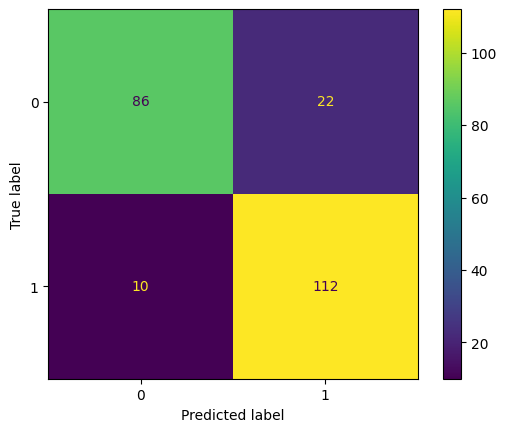

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier


# Initialize a K-Nearest Neighbors classifier with 36 neighbors
classifier = KNeighborsClassifier(n_neighbors=36)

# Train the classifier using the training data (X_train) and corresponding labels (y_train)
classifier.fit(X_train, y_train)

# Use the trained classifier to predict labels for the test data (X_test)
y_pred = classifier.predict(X_test)

# Print a classification report, which includes precision, recall, F1-score, and support
print(classification_report(y_test, y_pred))

# Print a separator line for better readability
print('\n')
print('------------------------')

# Print a header for the confusion matrix section
print('Confusion Matrix')

# Print a separator line for better readability
print('------------------------')
print('')

# Calculate the confusion matrix, which shows the counts of true positive, false positive,
# true negative, and false negative predictions
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()

# Show the plot
plt.show()

## Support Vector Classifier

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       108
           1       0.83      0.92      0.87       122

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



------------------------
Confusion Matrix
------------------------



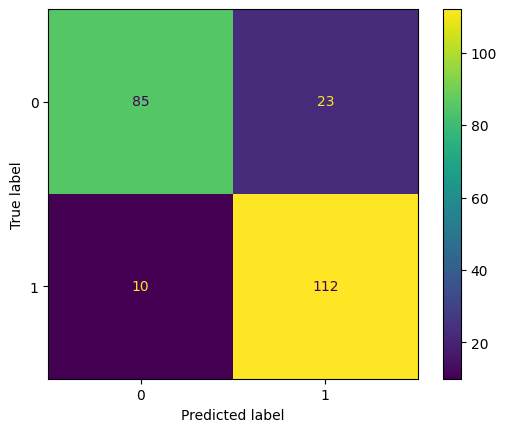

In [26]:
from sklearn.svm import SVC

# Initialize a Support Vector Classifier (SVC) with a radial basis function (RBF) kernel
# and a random state for reproducibility
classifier = SVC(kernel='rbf', random_state=100)

# Train the classifier using the training data (X_train) and corresponding labels (y_train)
classifier.fit(X_train, y_train)

# Use the trained classifier to predict labels for the test data (X_test)
y_pred = classifier.predict(X_test)

# Print a classification report, which includes precision, recall, F1-score, and support
print(classification_report(y_test, y_pred))

# Print a separator line for better readability
print('\n')
print('------------------------')

# Print a header for the confusion matrix section
print('Confusion Matrix')

# Print a separator line for better readability
print('------------------------')
print('')

# Calculate the confusion matrix, which shows the counts of true positive, false positive,
# true negative, and false negative predictions
cm2 = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
dis = ConfusionMatrixDisplay(confusion_matrix=cm2)

# Plot the confusion matrix
dis.plot()


## Parameter selectikon for Random Forest Classifier

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=103, stop=300, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [28]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize a Random Forest classifier
rf = RandomForestClassifier()

# Create a RandomizedSearchCV object to search for best hyperparameters
# estimator: the model to be tuned, in this case, Random Forest classifier
# param_distributions: the random grid of hyperparameters to search over
# n_iter: number of parameter settings that are sampled, here 100
# cv: cross-validation splitting strategy, here 3-fold cross-validation
# verbose: controls the verbosity, here set to 2 for more detailed output
# random_state: seed used to ensure reproducibility
# n_jobs: number of jobs to run in parallel, -1 means using all processors
forest = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object on the training data
forest.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [103, 124, 146, 168,
                                                         190, 212, 234, 256,
                                                         278, 300]},
                   random_state=42, verbose=2)

In [30]:
forest.best_params_

{'n_estimators': 124,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

## Random Forest Classifier

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        92
           1       0.85      0.88      0.87       138

    accuracy                           0.83       230
   macro avg       0.83      0.82      0.83       230
weighted avg       0.83      0.83      0.83       230


------------------------
Confusion Matrix
------------------------

[[ 70  22]
 [ 16 122]]


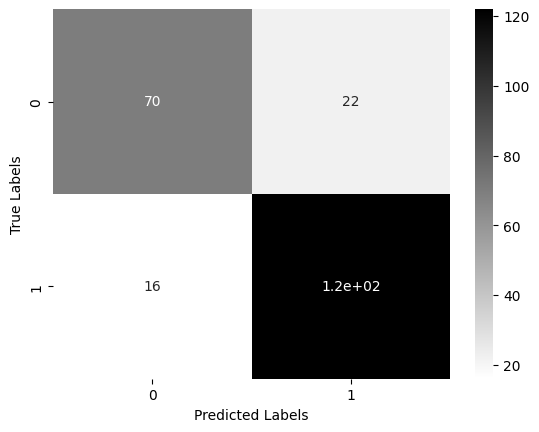

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Initialize a Random Forest classifier with specified hyperparameters
clf = RandomForestClassifier(n_estimators=124, min_samples_split=2,
                             min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Use the trained classifier to predict labels for the test data
y_pred = clf.predict(X_test)


# Print a classification report, which includes precision, recall, F1-score, and support
print(classification_report(y_test, y_pred))
print('')

# Print a separator line for better readability
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')

# Print the confusion matrix, which shows the counts of true positive, false positive,
# true negative, and false negative predictions
print(confusion_matrix(y_test, y_pred))

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='binary')

# Set the axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


## Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        92
           1       0.84      0.91      0.87       138

    accuracy                           0.84       230
   macro avg       0.84      0.83      0.83       230
weighted avg       0.84      0.84      0.84       230


------------------------
Confusion Matrix
------------------------

[[ 69  23]
 [ 13 125]]


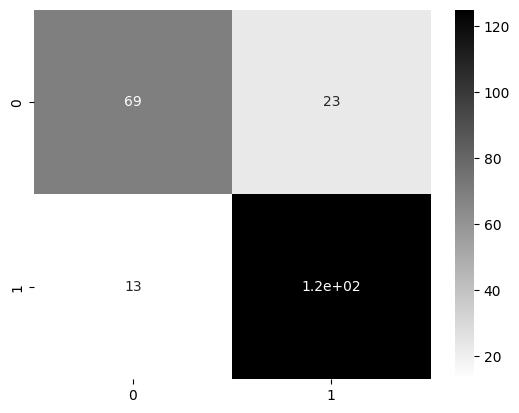

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize a Gradient Boosting classifier with specified hyperparameters
clff = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=1, random_state=23)

# Train the classifier on the training data
clff.fit(X_train, y_train)

# Use the trained classifier to predict labels for the test data
y_pred = clff.predict(X_test)

# Print a classification report, which includes precision, recall, F1-score, and support
print(classification_report(y_test, y_pred))
print('')

# Print a separator line for better readability
print('------------------------')
print('Confusion Matrix')
print('------------------------')
print('')

# Print the confusion matrix, which shows the counts of true positive, false positive,
# true negative, and false negative predictions
print(confusion_matrix(y_test, y_pred))

# Plot the confusion matrix using the plot_confusion_matrix function
# cmap="binary" sets the color map to binary (black and white)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='binary')

# Turn off grid lines for better visualization
plt.grid(False)

# Display the confusion matrix plot
plt.show()


In [33]:
# Reset warning behavior to default
warnings.filterwarnings('default')

## Conclusion


Since the goal is to predict the presence or absence of heart disease, it's essential to consider both false positives (predicting presence when it's absent) and false negatives (predicting absence when it's present). In medical diagnosis, false negatives (missing cases of heart disease) can be more critical than false positives.


### KNN Model Results Explained 
To prioritize minimizing false negatives (missing positive cases), we want to focus on the recall for class 1, which is 92%. Conversely, if we want to minimize false positives (incorrectly identifying negative cases as positive), we prioritize precision for class 0, which is 90%.

Considering the overall performance, a high F1-score indicates a balance between precision and recall. In this case, class 1 has a slightly higher F1-score 88% compared to class 0 84%, suggesting a better balance between precision and recall for the presence of the condition.

### Support Vector Classifier model Results Explained
To prioritize minimizing false negatives (missing positive cases), we want to focus on the recall for class 1, which is 92%. Conversely, if we want to minimize false positives (incorrectly identifying negative cases as positive), we prioritize precision for class 0, which is 89%.

Considering the overall performance, a high F1-score indicates a balance between precision and recall. In this case, class 1 has a slightly higher F1-score 87% compared to class 0 84%, suggesting a better balance between precision and recall for the presence of the condition.


### Random Forest Classifier Results Explained

To choose the appropriate model, you should consider the balance between precision and recall. A higher recall indicates fewer false negatives, meaning the model is better at identifying cases of heart disease when they are present.

In this case, the model achieves a higher recall for class 1 89%, suggesting it's better at identifying cases of heart disease.


### Gradient Boosting Classifier Results Explained

Considering both precision and recall, we should focus on the recall metric, especially for class 1 (presence of heart disease). A higher recall indicates better performance in identifying cases of heart disease when they are present.

In this case, the model achieves a recall of 91% for class 1, which means it correctly identifies 91% of the cases of heart disease. This indicates that the model is better at identifying cases of heart disease, which is crucial for a heart disease prediction model.


Based on the provided classification reports, we can assess the performance of each model:

K-Nearest Neighbors (KNN) Classifier:
   - Accuracy: 0.86
   - F1-score (weighted average): 0.86
   
Support Vector Classifier (SVC) with RBF Kernel:
   - Accuracy: 0.84
   - F1-score (weighted average): 0.84
    
Gradient Boosting Classifier:
   - Accuracy: 0.84
   - F1-score (weighted average): 0.84
   
Random Forest Classifier:
   - Accuracy: 0.86
   - F1-score (weighted average): 0.86

Considering both accuracy and F1-score, the Random Forest Classifier and the K-Nearest Neighbors (KNN) Classifier have the highest performance, each achieving an accuracy of 0.86 and an F1-score of 0.86.

Therefore, you might consider either the Random Forest Classifier or the K-Nearest Neighbors (KNN) Classifier as the best models for heart disease prediction, depending on other factors such as interpretability, computational efficiency, and specific requirements of your application. If interpretability and simplicity are important, KNN might be preferred. 

I prioritize performance and robustness, <b> Random Forest </b> is a better choice.
